In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))  # set vscode notebook path for module imports

from db.repo import ResultsRepository
from db.mongo import MongoWrapper
from pipeline.config import settings

import pandas as pd
import matplotlib.pyplot as plt

import math

In [2]:
mongo = MongoWrapper(settings.MONGO_URI_PROD, settings.MONGO_DB) #mongo client
repo = ResultsRepository(mongo_client=mongo, repo=settings.MONGO_COLLECTION) #mongo repo

In [3]:
df = pd.DataFrame(list(repo.col.find({'winter_year': 2025}, {'_id': False})))

In [7]:
base_hdd = pd.read_csv('../utils/files/base_revised.csv')
base_hdd = base_hdd.rename(columns={'Unnamed: 0': 'Day of year'})
base_hdd = base_hdd.set_index('Day of year')

In [8]:
df_obs = df[df['data_type'] == 'observation']
df_forecast = df[df['data_type'] == 'forecast']
df_obs['doy'] = df_obs['time'].dt.dayofyear
df_forecast['doy'] = df_forecast['valid_time'].dt.dayofyear

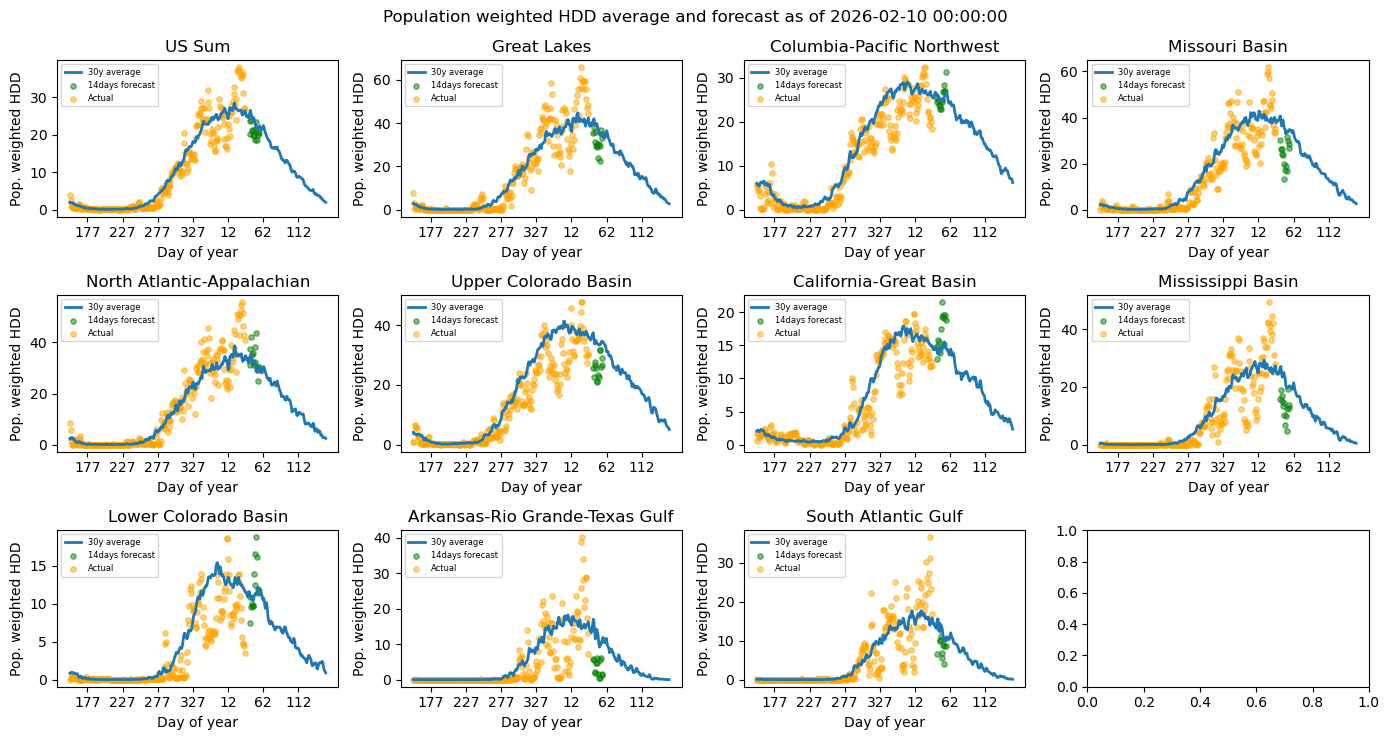

In [ ]:
base_hdd_rearranged = pd.concat([base_hdd.loc[213:365], base_hdd.loc[0:212]]) #rearrange from 1st august to 31 july

cols = 4
rows = math.ceil(len(base_hdd_rearranged.columns) / cols)

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 2.5 * rows))
ax = ax.flatten()

tick_positions = range(25, len(base_hdd_rearranged), 50)  #Every 50 days
tick_labels = [base_hdd_rearranged.index[pos] for pos in tick_positions]

for i, col in enumerate(base_hdd_rearranged.columns):
    df_forecast_region = df_forecast[df_forecast['region'] == col]
    df_obs_region = df_obs[df_obs['region'] == col]
    ax[i].plot(base_hdd_rearranged[col].values, linewidth=2, label='30y average')
    ax[i].scatter(df_forecast_region['doy'], df_forecast_region['hdd'], s=15, alpha=0.5, color='green', label='14days forecast')
    ax[i].scatter(df_obs_region['doy'], df_obs_region['hdd'], s=15, alpha=0.5, color='orange', label='Actual')
    ax[i].set_title(f'{col}')
    ax[i].set_xticks(tick_positions)
    ax[i].set_xticklabels(tick_labels)
    ax[i].set_xlabel('Day of year')
    ax[i].set_ylabel('Pop. weighted HDD')
    ax[i].legend(fontsize=6)
plt.suptitle(f'Population weighted HDD average and forecast as of {df_forecast['time'].unique()[0]}')
plt.tight_layout()
plt.show()